In [19]:
#from https://epic.awi.de/id/eprint/55839/1/Master_Thesis_Endurance_Igbniosa.pdf

""""
     PI             LIG
Jan  02Jan - 30Jan  26Dec - 27Jan
Feb  31Jan - 01Mar  28Jan - 28Feb
Mar  02Mar - 31Mar  01Mar - 31Mar
Apr  01Apr - 01May  01Apr - 30Apr
May  02May - 01Jun  01May - 29May
Jun  02Jun - 02Jul  30May - 26Jun
Jul  03Jul - 02Aug  27Jun - 24Jul
Aug  03Aug - 02Sep  25Jul - 22Aug
Sep  03Sep - 03Oct  23Aug - 20Sep
Oct  04Oct - 02Nov  21Sep - 21Oct
Nov  03Nov - 02Dec  22Oct - 22Nov
Dec  03Dec - 01Jan  23Nov - 25Dec
"""

'"\n     PI             LIG\nJan  02Jan - 30Jan  26Dec - 27Jan\nFeb  31Jan - 01Mar  28Jan - 28Feb\nMar  02Mar - 31Mar  01Mar - 31Mar\nApr  01Apr - 01May  01Apr - 30Apr\nMay  02May - 01Jun  01May - 29May\nJun  02Jun - 02Jul  30May - 26Jun\nJul  03Jul - 02Aug  27Jun - 24Jul\nAug  03Aug - 02Sep  25Jul - 22Aug\nSep  03Sep - 03Oct  23Aug - 20Sep\nOct  04Oct - 02Nov  21Sep - 21Oct\nNov  03Nov - 02Dec  22Oct - 22Nov\nDec  03Dec - 01Jan  23Nov - 25Dec\n'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from datetime import datetime
from scipy.interpolate import CubicSpline

: 

In [ ]:
def cal_from_line(line, vernal_day=80, months_to_switch=3):
    cal = line.copy()
    for i in range(len(line)): 
        cal[i] = line[i] + vernal_day if line[i] + vernal_day <= 365 else line[i] + vernal_day - 365

    #put the last three months at the beginning
    cal = cal[-months_to_switch:] + cal[:-months_to_switch]
    return cal

: 

In [3]:
def paleo_cal_adjust(cal, data, standard_month_length=30):
     
     #create a blank variable of the same type as 'data', but with 360 columns
     #this is to store the interpolated data
     interpolated_data = np.zeros((data.shape[0], 360))

     for i in range(len(cal)):
     
          if cal[0] > cal[1]:
               if i == 0:
                    month_slice = xr.concat([data[:,cal[i]-1:data.shape[1]-1], data[:,0:cal[1]-1]], dim='day')
                    month_slice['day'] = np.arange(1,month_slice.shape[1]+1)
                    
               elif i == len(cal)-1:
                    month_slice = data[:,cal[i]-1:cal[0]-1]
               else:
                    month_slice = data[:,cal[i]-1:cal[i+1]-1]     
          else:          
               if i == len(cal)-1:
                    #get the last slice and first slice and combine them
                    #month_slice = data[:,cal[i]-1:data.shape[1]-1] + data[:,0:cal[0]]
                    month_slice = xr.concat([data[:,cal[i]-1:data.shape[1]-1], data[:,0:cal[0]-1]], dim='day')
                    month_slice['day'] = np.arange(1,month_slice.shape[1]+1)
                    
               else:
                    #need to add code to handle January starting in Dec (i.e. cal[0] is greater than cal[1])
                    month_slice = data[:,cal[i]-1:cal[i+1]-1]
          
          days = month_slice.day
          insolation = month_slice.values

          x_old= np.arange(len(days) + 1)
          cs = CubicSpline(days,insolation,axis=1)
          x_new = np.linspace(days[0], days[-1], 30)
          y_new = cs(x_new)

          interpolated_data[:,i*standard_month_length:(i+1)*standard_month_length] = np.maximum(y_new,0) #remove negative values from interpolation


     interpolated_data = xr.DataArray(interpolated_data, coords=[data.lat, np.arange(360)], dims=['lat', 'day'])
     return interpolated_data

In [4]:
piline=[11,41,72,102,133,164,194,225,255,286,317,345]
mhline=[12,43,74,103,133,162,191,221,251,283,315,345]
ligline=[12,41,70,97,125,154,183,215,247,281,315,345]

In [ ]:
#pi_cal = cal_from_line(piline, 80)
#lig_cal = cal_from_line(ligline, 80)    

lig_cal = [360,29,59,91,120,149,175,203,232,261,293,326] #from paleo cal adjust git hub N.B +1 added to all values to be in the format for this code
pi_cal = [1,32,60,91,121,152,182,213,244,274,305,335] 
print(pi_cal)
print(lig_cal)


[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
[360, 29, 59, 91, 120, 149, 175, 203, 232, 261, 293, 326]


In [6]:
fi = xr.open_dataset('insolation180.nc',decode_times=False)
day=fi['day']
lat=fi['lat']
pi1=fi['piControl']
lig1=fi['lig127k']
mh1=fi['midHolocene']
lig=fi['lig127k']*0
mh=fi['midHolocene']*0
pi=fi['piControl']*0

In [28]:
pi_proper = paleo_cal_adjust(pi_cal, pi1)
lig_proper = paleo_cal_adjust(lig_cal, lig1)

anomalies = lig_proper - pi_proper


In [29]:
from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('', ['darkblue','blue','lightblue','white', 'yellow','orange','red'])

In [30]:

from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
cmap=LinearSegmentedColormap.from_list('', ['indigo','darkblue','blue','lightblue','white', 'pink', 'red', 'orange','yellow'])
#cmap=plt.get_cmap('seismic')
bounds =[-200,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,200]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)


<a list of 26 text.Text objects>

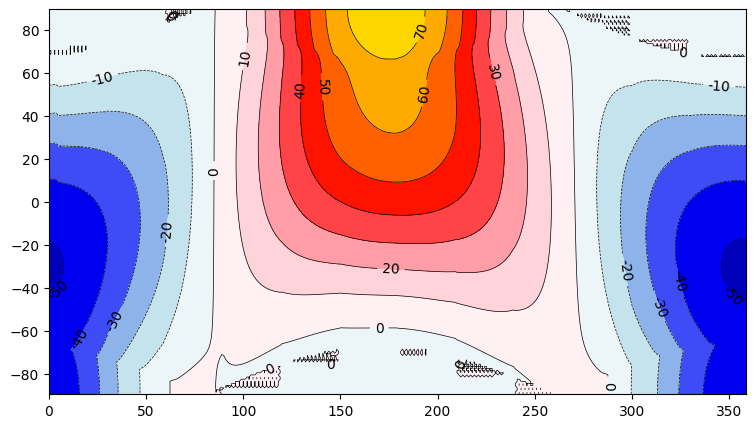

In [31]:
#cmap=plt.get_cmap('seismic')
fig, ax = plt.subplots(figsize=(9, 5))
anomalies_smooth = gaussian_filter(anomalies, sigma=5.0)
fig1=ax.contourf(np.arange(360),lat,anomalies,levels=bounds,cmap=cmap,norm=norm)
#add contour lines

CS=ax.contour(np.arange(360),lat,anomalies,levels=bounds,colors='black',linewidths=0.5)
ax.clabel(CS, inline=1, fontsize=10, fmt='%1.0f')

<a list of 36 text.Text objects>

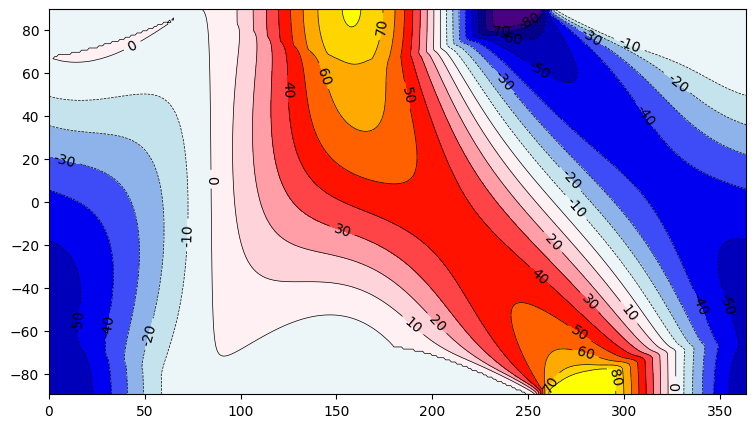

In [11]:

fig, ax = plt.subplots(figsize=(9, 5))
fig1=ax.contourf(np.arange(365),lat,lig1-pi1,levels=bounds,cmap=cmap,norm=norm)
#add contour lines
CS=ax.contour(np.arange(365),lat,lig1-pi1,levels=bounds,colors='black',linewidths=0.5)
ax.clabel(CS, inline=1, fontsize=10, fmt='%1.0f')

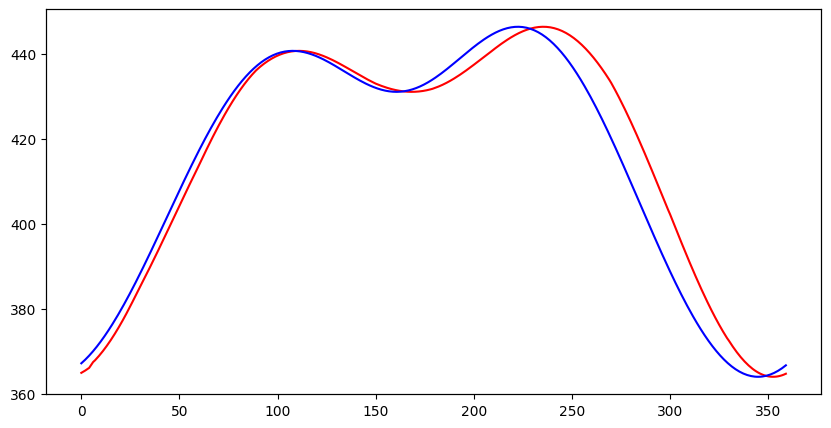

In [12]:
#line plot


fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.arange(360), lig_proper[90, :], label='Adjusted', c='r')

ax2 = ax.twiny()

ax2.plot(np.arange(365), lig1[90, :], label='Original', c='b')
ax2.xaxis.set_visible(False)

In [13]:
def orbital_month_lengths(e, obliquity, perihelion, T=365.2422):
    """
    Calculates the length (in days) of each "month" for an elliptical orbit,
    where a month is defined as the time required for the ecliptic longitude 
    to advance by 30°.
    
    Parameters:
      e           : orbital eccentricity.
      obliquity   : axial tilt in degrees (not used in this basic model).
      perihelion  : ecliptic longitude of perihelion in degrees (relative to the vernal equinox).
      T           : orbital period in days (default 365.2422).
      
    Assumptions:
      - The vernal equinox is fixed at ecliptic longitude 0°, occurring at noon on March 21.
      - At the vernal equinox the true anomaly is θ₀ = -perihelion (in radians).
      - The 12 month boundaries are defined by ecliptic longitudes 0°, 30°, ..., 330°.
      - The orbital segment that begins at the vernal equinox is assigned to March.
        (Thus, when reporting calendar months the order is:
         January, February, March, …, December, where January corresponds to the segment
         two steps before March.)
    
    Returns:
      A dictionary mapping calendar month names (January, February, …, December)
      to their lengths in days.
    """
    # Convert perihelion to radians
    phi = np.radians(perihelion)
    
    # Define the 12 boundaries in ecliptic longitude (0°, 30°, …, 330°) in radians.
    boundaries = np.radians(np.arange(0, 360, 30))
    
    # For each boundary, the corresponding true anomaly is:
    #   θ = λ - phi
    theta = boundaries - phi  # array of 12 values
    
    # Compute eccentric anomaly E from true anomaly using:
    #   cos(E) = (e + cosθ) / (1 + e*cosθ)
    #   sin(E) = (sqrt(1-e^2)*sinθ) / (1 + e*cosθ)
    cosE = (e + np.cos(theta)) / (1 + e * np.cos(theta))
    sinE = (np.sqrt(1 - e**2) * np.sin(theta)) / (1 + e * np.cos(theta))
    # Use arctan2 to get the correct quadrant, then ensure E is in [0, 2π)
    E = np.mod(np.arctan2(sinE, cosE), 2*np.pi)
    
    # Compute mean anomaly: M = E - e*sin(E)
    M = E - e * np.sin(E)
    
    # Now compute the duration for each 30° segment.
    # For each segment k, the time difference is Δt = T*( (M[k+1]-M[k]) mod 2π )/(2π)
    month_durations = np.empty(12)
    for k in range(12):
        next_k = (k + 1) % 12
        dM = (M[next_k] - M[k]) % (2*np.pi)
        month_durations[k] = T * dM / (2*np.pi)
    
    # The boundaries were defined starting at vernal equinox (λ = 0) which is fixed to March 21.
    # We assign the segment starting at vernal equinox to March.
    # Thus the segments in order (index 0 to 11) correspond to:
    #   0: March, 1: April, …, 9: December, 10: January, 11: February.
    #
    # To report in calendar order starting with January, we need to rotate the array:
    #   January: segment index 10
    #   February: segment index 11
    #   March: segment index 0, and so on.
    reordered = np.empty(12)
    reordered[0] = month_durations[10]  # January
    reordered[1] = month_durations[11]  # February
    reordered[2:12] = month_durations[0:10]  # March to December
    
    month_names = ["January", "February", "March", "April", "May", "June", 
                   "July", "August", "September", "October", "November", "December"]
    
    return dict(zip(month_names, reordered))


In [14]:
lig_cal_calc_lengths = orbital_month_lengths(0.039378, 24.040, 275.41, 365)
values = list(lig_cal_calc_lengths.values())

print(values)

[28.605111396536056, 29.54111425261457, 30.746604817863485, 31.911723622422254, 32.68816676329023, 32.817117460370916, 32.25352295967309, 31.189951212689675, 29.959137569012274, 28.8961680085186, 28.24745644268301, 28.14392549432585]


In [15]:
print(lig_cal)

[359, 28, 58, 90, 119, 148, 174, 202, 231, 260, 292, 325]


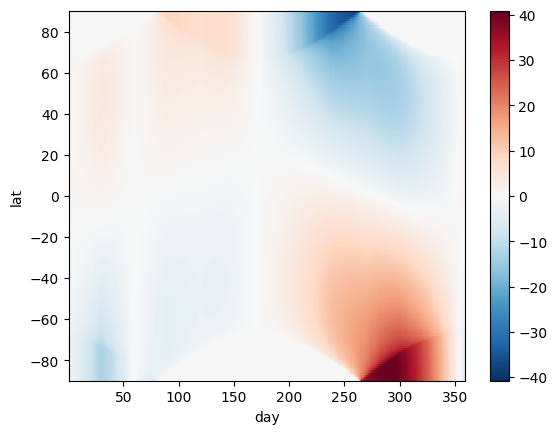

In [16]:
pi_adjust = pi_proper - pi1
pi_adjust.plot()

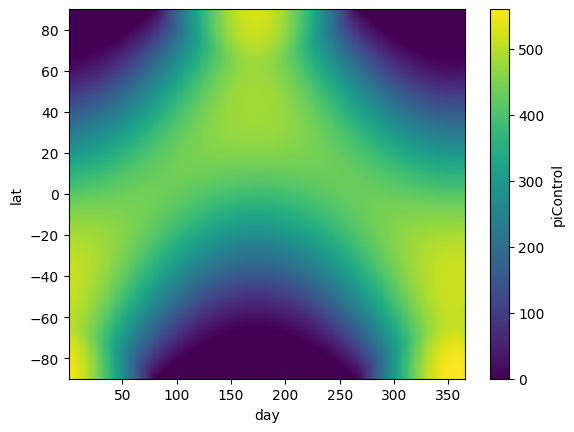

In [17]:
pi1.plot()

In [18]:
print(pi_cal)


[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
